### Importing libraries

In [73]:
# Import for exploration and visualization
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os

# import sklearn and xgboost libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold


### Data exploration ###

In [74]:
# Use panda to read the csv, using the head() method you can check the first 5 rows
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [76]:
train.info()
# The .info() method gives a quick summary of the df structure.
# In this case, the dataset has 891 rows and 12 columns.
# For each column, it shows:
#   - The column index (position in the df)
#   - The column name
#   - The number of non-null (non-missing) values
#   - The data type (dtype) of the column
# This information is useful for:
#   - Detecting missing values
#   - Understanding data types before cleaning or transformation
#   - Getting a sense of the dataset size and memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [77]:
train.describe() # describe gives you statistical summaries of the df
# count	Number of non-missing values
# mean  -   Average value
# std   -   Standard deviation (spread of data)
# min   -	Minimum value
# 25%   -	1st quartile (25% of data ≤ this value)
# 50%   -   Median (middle value)
# 75%   -	3rd quartile (75% of data ≤ this value)
# max   -	Maximum value

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [78]:
train.describe(include='object')
# you can use this to include objects to get info in the non-numeric columns
# unique    -   number of distinct values
# top       -   most common value
# freq      -   how many times that top value appears   

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [79]:
# Using describe() shows that most passengers did not survive. 
# This means the 'Survived' column can be used as a target variable to analyze and compare the characteristics of survivors vs. non-survivors in the dataset.
survi_mean = train.groupby("Survived").mean(numeric_only=True)
survi_0 = survi_mean.iloc[0,:] # avergage values of passenger that DID not survive
survi_1 = survi_mean.iloc[1,:] # avergage values of passenger DID not survive
# Relative difference calculation
# This highlights which features differ most proportionally between the two groups, helping identify potential predictors of survival.
abs((survi_1 - survi_0) / (survi_0 + survi_1))

PassengerId    0.002971
Pclass         0.129755
Age            0.038706
SibSp          0.077914
Parch          0.170176
Fare           0.372661
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

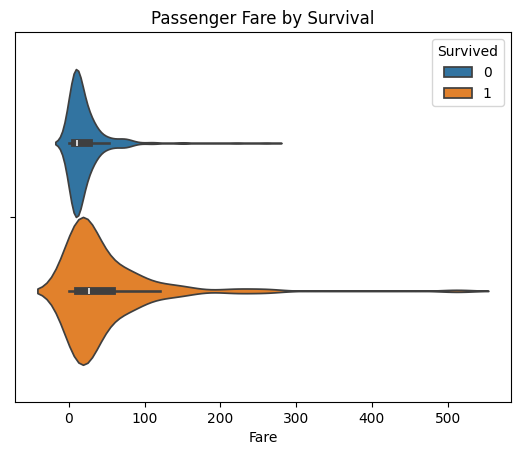

In [80]:
# The relative differences show that Fare, Parch, and Pclass matter the most for survival.
# Let's explore these features further to understand their impact,
# which will help us gauge how much importance our XGBoost model should assign to them.
# Fare by survival
sns.violinplot(x="Fare", hue="Survived", data=train)
plt.title("Passenger Fare by Survival")
plt.show

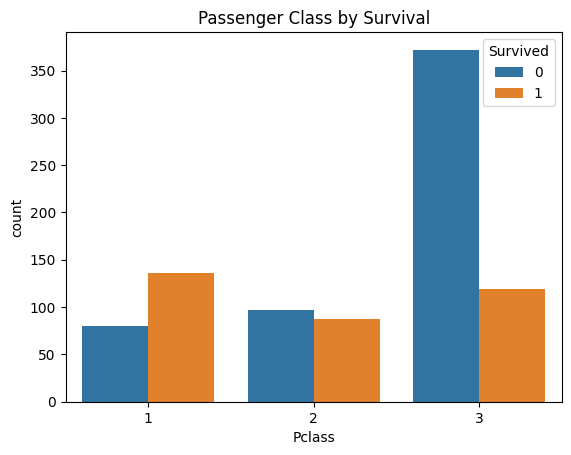

In [81]:
# Pclass by survival
sns.countplot(x="Pclass", hue="Survived", data=train)
plt.title("Passenger Class by Survival")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

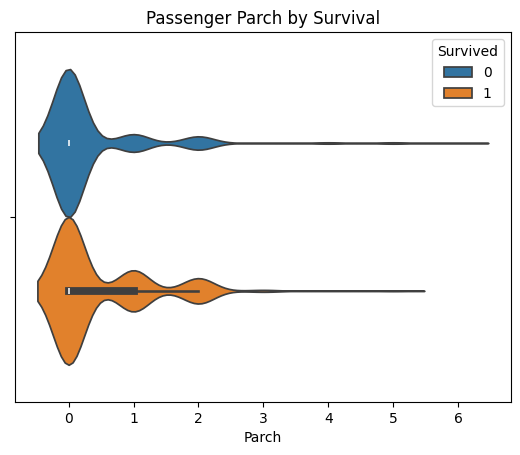

In [82]:
# Parch by survival
sns.violinplot(x="Parch", hue="Survived", data=train)
plt.title("Passenger Parch by Survival")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

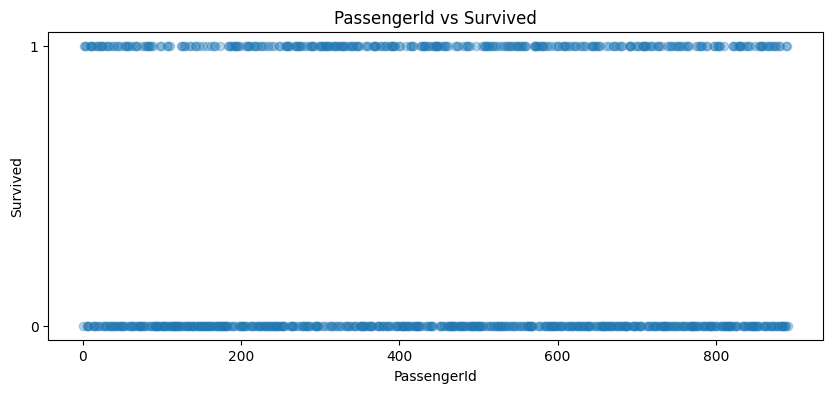

In [83]:
# For context, let's see the PassengerId value impact so we can see how little it matters
plt.figure(figsize=(10,4))
plt.scatter(train["PassengerId"], train["Survived"], alpha=0.3)
plt.xlabel("PassengerId")
plt.ylabel("Survived")
plt.title("PassengerId vs Survived")
plt.yticks([0,1])
plt.show

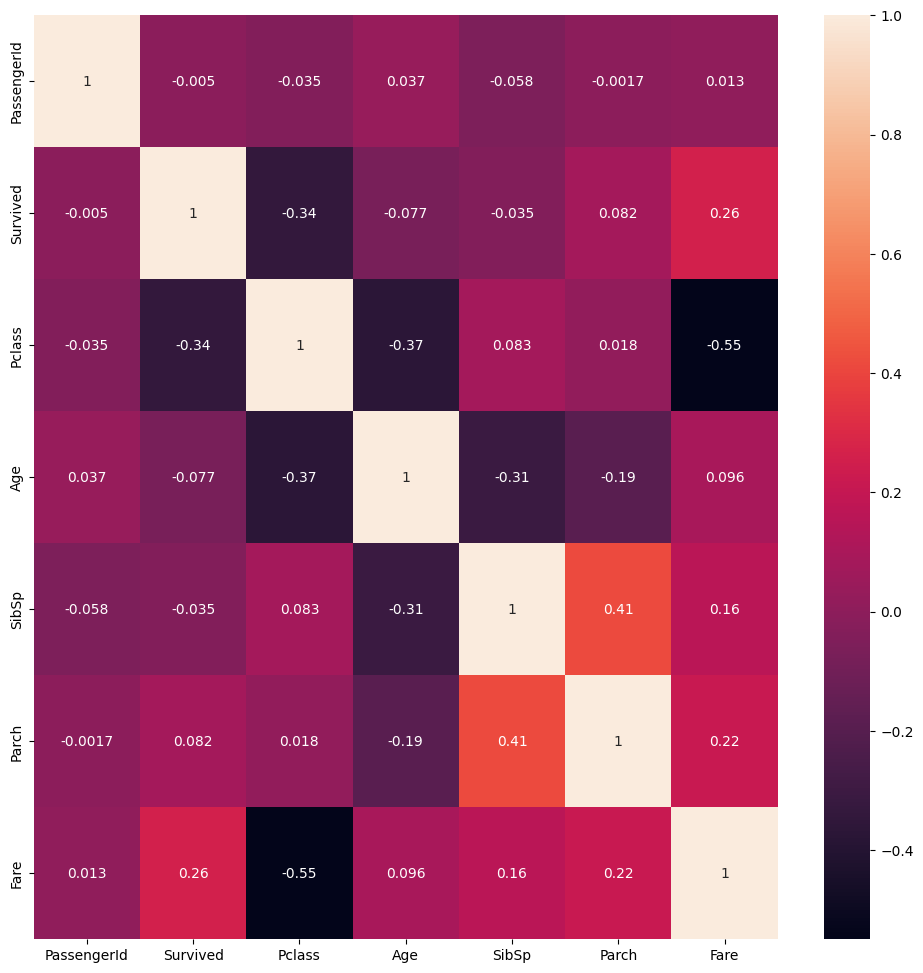

In [84]:
# Calculate the correlation matrix for all numeric features in the dataset.
# Then plot a heatmap to visually inspect the strength and direction of linear relationships between pairs of numeric variables.
# The heatmap's colors and annotated values help identify which features are strongly
# positively or negatively correlated, which is useful for feature selection and understanding data structure.
corr = train.select_dtypes(include="number").corr()
plt.subplots(figsize=(12, 12))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

In [85]:
# Analyzing this, we can check that, for example, the correlation with Survival is:
# -0.005 with PassengerID, Almost no correlation, meaning that it has practically no correlation
# 1 with Survived, perfect correlation with itself, for obvious reasons
# -0.34 with Pclass, Moderate negative correlation, higher class (lower number) means MORE likely to survive
# -0.077 with Age, Weak negative correlation, younger passengers slightly more likely to survive
# -0.035 with SibSp, Weak negative correlation, having siblings/spouses means almost nothing when it comes to survive
# 0.082 with Parch, Weak positive correlation, having parents/childrens means almost nothing when it comes to survive
# 0.26 with Fare, Moderate positive correlation, paying higher fares increases chance of survival+

### Preprocessing data ###

In [86]:
print(train["Name"].head())

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object


In [87]:
# Extract title using regex
train["title"] = train["Name"].str.extract(r",\s*([^\.\"]+)\.", expand=False)

# Map titles to numeric codes using a dictionary
title_mapping = {
    "Mr": 1,
    "Master": 3,
    "Ms": 4, "Mlle": 4, "Miss": 4,
    "Mme": 5, "Mrs": 5
}

# Map titles, assign 2 to all others (including unknown)
train["title"] = train["title"].map(title_mapping).fillna(2).astype(int)

print(train["title"])


0      1
1      5
2      4
3      5
4      1
      ..
886    2
887    4
888    4
889    1
890    1
Name: title, Length: 891, dtype: int32


In [88]:
# Convert Fare to True if above average, else False
meanfare = train["Fare"].mean()
train["Fare"] = train["Fare"] > meanfare
print(train["Fare"])

0      False
1       True
2      False
3       True
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Name: Fare, Length: 891, dtype: bool


In [89]:
# With that, lets start from droping some values we don't need.
train = train.drop(["PassengerId","Name","Ticket"], axis="columns")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    bool   
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
 9   title     891 non-null    int32  
dtypes: bool(1), float64(1), int32(1), int64(4), object(3)
memory usage: 60.2+ KB


In [90]:
# Lets replace the values of sex with numbers so its easier for the model to work with
train["Sex"] = train["Sex"].replace(["male", "female"], [0,1])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    bool   
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
 9   title     891 non-null    int32  
dtypes: bool(1), float64(1), int32(1), int64(5), object(2)
memory usage: 60.2+ KB


In [91]:
# Since cabin either is null or has a random alphanumeric value, lets make it a boolean
train["Cabin"] = train["Cabin"].isna()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    bool   
 7   Cabin     891 non-null    bool   
 8   Embarked  889 non-null    object 
 9   title     891 non-null    int32  
dtypes: bool(2), float64(1), int32(1), int64(5), object(1)
memory usage: 54.1+ KB


In [92]:
mean_ages = train.groupby("title")["Age"].agg("mean")
print(mean_ages)

title
1    32.368090
2    45.545455
3     4.574167
4    21.845638
5    35.788991
Name: Age, dtype: float64


In [93]:
# Mapping from title to age to fill missing values
title_age_map = {
    1:32,
    2:45,
    3:7,
    4:23,
    5:35,
}

# Fill missing Age values based on title
train["Age"] = train["Age"].fillna(train["title"].map(title_age_map))

# Fill any remaining missings using the mean
mean_age =  train["Age"].mean()
train["Age"] = train["Age"].fillna(mean_age)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,title
0,0,3,0,22.0,1,0,False,True,S,1
1,1,1,1,38.0,1,0,True,False,C,5
2,1,3,1,26.0,0,0,False,True,S,4
3,1,1,1,35.0,1,0,True,False,S,5
4,0,3,0,35.0,0,0,False,True,S,1


In [94]:
# Converts categorical variables in the DataFrame into one-hot encoded columns, creating new binary columns for each category value,so machine learning models can process categorical data easily
train = pd.get_dummies(train)
# So now we do this again after the data treatment
survi_mean = train.groupby("Survived").mean()
survi_0 = survi_mean.iloc[0,:] 
survi_1 = survi_mean.iloc[1,:] 
abs((survi_1 - survi_0) / (survi_0 + survi_1))

Pclass        0.129755
Sex           0.643977
Age           0.040050
SibSp         0.077914
Parch         0.170176
Fare          0.408208
Cabin         0.185190
title         0.374197
Embarked_C    0.331221
Embarked_Q    0.012168
Embarked_S    0.101449
dtype: float64

### Modeling ###

In [95]:
# Remove the Survived column from train and assign it to y (target variable), leaving train with only feature columns which we assign to x (input features)
y = train["Survived"]
x = train.drop(columns=["Survived"])


In [96]:
# Basic XGBoost classifier usage
model = XGBClassifier()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.8603351955307262


In [97]:
# We check the prediction the model does for survivors
pred = model.predict(x_test)
print("Survived", sum(pred != 0))

Survived 59


In [98]:
# We check the prediction the model does for non-survivors
pred = model.predict(x_test)
print("Not Survived", sum(pred == 0))

Not Survived 120


In [99]:
# We use a confusion matrix to check how many TN, FP, FN and TP we have.
# [[TN, FP],   <-- First row: True Negatives (TN), False Positives (FP)
#  [FN, TP]]   <-- Second row: False Negatives (FN), True Positives (TP)
conmatrix = confusion_matrix(y_test, pred)
conmatrix

array([[106,  11],
       [ 14,  48]], dtype=int64)

In [100]:
# We obtained 86% accuracy with XGBoost model, now we might want to adjust its hyperparameter using GridSearch
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = XGBClassifier(random_state=42)  # fixes XGBoost's own RNG
ran_grid = {"eta": np.linspace(0, 0.5, num=12)}

ran = GridSearchCV(model, ran_grid, cv=cv_splitter)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=11
)

ran.fit(x_train, y_train)
print(ran.best_score_)
print(ran.best_params_)

0.8146951639909386
{'eta': 0.045454545454545456}


In [101]:
# We adjust max_depth
model = XGBClassifier(eta = 0.045454545454545456)
random_grid = {"max_depth": range(1,20,1)}

ran = GridSearchCV(model, random_grid, cv=5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
ran.fit(x_train, y_train)
print(ran.best_score_)
ran.best_params_

0.8216290751502019


{'max_depth': 6}

In [102]:
# We adjust min_child_weight
model = XGBClassifier(eta = 0.045454545454545456, max_depth = 6)
random_grid = {"min_child_weight": range(1,20,1)}

ran = GridSearchCV(model, random_grid, cv=5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
ran.fit(x_train, y_train)
print(ran.best_score_)
ran.best_params_


0.8216290751502019


{'min_child_weight': 1}

In [103]:
# We adjust gamma
model = XGBClassifier(eta = 0.045454545454545456, max_depth = 6, min_child_weight=1)
random_grid = {"gamma" : [i / 10.0 for i in range(0, 11)]}

ran = GridSearchCV(model, random_grid, cv=5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
ran.fit(x_train, y_train)
print(ran.best_score_)
ran.best_params_

0.821638924455826


{'gamma': 0.3}

In [104]:
# We adjust subsample
model = XGBClassifier(eta=0.045454545454545456, max_depth=6, min_child_weight=1, gamma=0.3)
random_grid = {"subsample": [i / 100.0 for i in range(50, 101, 5)]}

ran = GridSearchCV(model, random_grid, cv=5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
ran.fit(x_train, y_train)
print(ran.best_score_)
print(ran.best_params_)

0.821638924455826
{'subsample': 1.0}


In [105]:
# We adjust comsample_bytree
model = XGBClassifier(eta=0.045454545454545456, max_depth=6, min_child_weight=1, gamma=0.3, subsample=1.0)
random_grid = {"colsample_bytree": [i / 10.0 for i in range(5, 11)]}  # 0.5 to 1.0

ran = GridSearchCV(model, random_grid, cv=5)
ran.fit(x_train, y_train)
print(ran.best_score_)
print(ran.best_params_)

0.821638924455826
{'colsample_bytree': 1.0}


In [106]:
# We adjust reg_alpha
model = XGBClassifier(
    eta=0.045454545454545456,
    max_depth=6,
    min_child_weight=1,
    gamma=0.3,
    subsample=1.0,
    colsample_bytree=1.0
)
random_grid = {"reg_alpha": [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

ran = GridSearchCV(model, random_grid, cv=5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
ran.fit(x_train, y_train)
print(ran.best_score_)
print(ran.best_params_)

0.8258544272628778
{'reg_alpha': 0.05}


In [107]:
# We check how we doing isn 92,17% accuracy
model = XGBClassifier(
    eta=0.045454545454545456,
    max_depth=6,
    min_child_weight=1,
    gamma=0.3,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha = 0.05
)

model.fit(x, y)
print(model.score(x_test, y_test))
pred = model.predict(x_test)
print("Survived", sum(pred!=0))
print("Not Survived", sum(pred==0))

conmatrix = confusion_matrix(y_test, pred)
conmatrix

0.9217877094972067
Survived 57
Not Survived 122


array([[113,   5],
       [  9,  52]], dtype=int64)

We trained the XGBoost model with the best hyperparameters found via GridSearchCV
We achieve 92.17% accuracy on the test set (x_test, y_test)
Then we predict the 'Survived' labels and print how many passengers the model predicts survived and not survived
Finally, we compute the confusion matrix to evaluate performance in detail:
 - 113 true negatives (correctly predicted not survived)
 - 52 true positives (correctly predicted survived)
 - 5 false positives (predicted survived but actually did not survive)
 - 9 false negatives (predicted not survived but actually survived)

In [108]:
import joblib
joblib.dump(model, "titanic_xgb_92_17.pkl")
# Save the fully processed dataset for testing or deployment
train.to_csv(r"e:\Cosas de Portatil\Uni\Work\AI\Titanic_Survival_Prediction\data\processed_titanic.csv", index=False)